In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [2]:
training_folder = '../../datasets/data21k_kaggle/train_images/'
samples_df = pd.read_csv("../../datasets/data21k_kaggle/train.csv")
samples_df["label"] = samples_df["label"].astype("str")
samples_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
samples_df = samples_df.query("label=='4'")

In [4]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

# Test 2 vegetation indices for RGB images
Below, we are implementing functions that return the process vegetation indices:

Elliptical Color Index (ECI)  <br/>
Color Index Vegetation Extraction (CIVE) 

In [5]:
def get_ECI_band(img):
    '''
    Return the ECI band calculated from an RGB image between 0 and 255
    using the formula below:    
    ECI = (red_channel-1)^2 + green_channel^2/0.16
    '''
    img = img/255.
    img = cv2.GaussianBlur(img,(35,35),0)
    ECI_band = np.power(img[:,:,0]-1,2) + np.power(img[:,:,1],2)/0.16
    normalized_ECI_band = (ECI_band/ECI_band.max()*255).astype(np.uint8)
    return normalized_ECI_band


def get_CIVE_band(img):
    '''
    Return the CIVE band calculated from an RGB image between 0 and 255
    using the formula below:
    CIVE = 0.441*red_channel - 0.881*green_channel + 0.385*blue_channel + 18.787
    '''
    img = cv2.GaussianBlur(img,(35,35),0)
    CIVE_band = 0.441*img[:,:,0] - 0.881*img[:,:,1] + 0.385*img[:,:,2] + 18.787
    normalized_CIVE_band = (((CIVE_band+abs(CIVE_band.min()))/CIVE_band.max())).astype(np.uint8)
    return normalized_CIVE_band


def apply_ECI_mask(img, vegetation_index_band):
    '''
    Apply a binary mask on an image and return the masked image
    '''
    ret, otsu = cv2.threshold(vegetation_index_band,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masked_img = cv2.bitwise_and(img,img,mask = otsu)
    return masked_img


def apply_CIVE_mask(img, vegetation_index_band):
    '''
    Apply a binary mask on an image and return the masked image
    '''
    ret, otsu = cv2.threshold(vegetation_index_band,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    masked_img = cv2.bitwise_and(img,img,mask = otsu)
    return masked_img

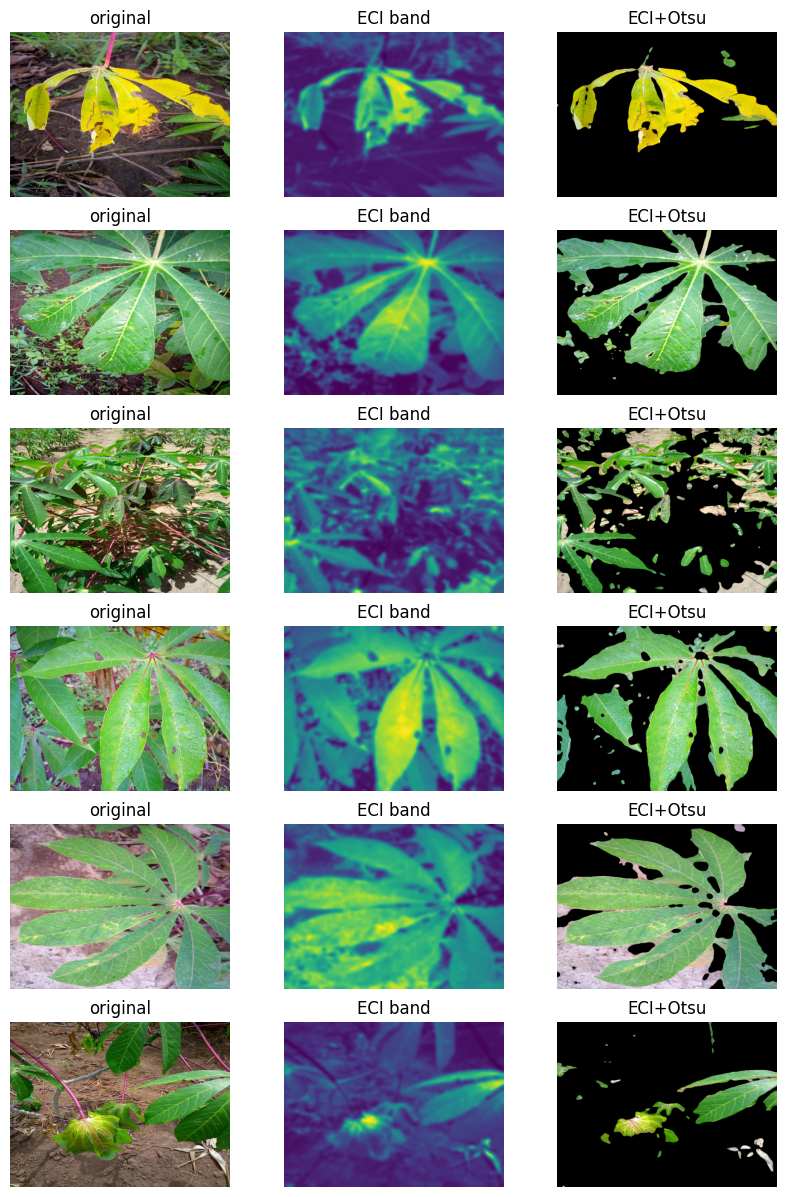

In [6]:
plt.figure(figsize=(10, 15))
items = 6
for idx, image_id in enumerate(samples_df.image_id[:items]):
   img_path = training_folder+image_id
   img = np.array(Image.open(img_path))
   ax = plt.subplot(items, 3, idx*3 + 1)
   ax.set_title("original")
   plt.axis('off')
   plt.imshow(img)
   
   ECI_band =  get_ECI_band(img)
   ax = plt.subplot(items, 3, idx*3 + 2)
   ax.set_title("ECI band")
   plt.axis('off')
   plt.imshow(ECI_band)
   
   masked_img = apply_ECI_mask(img, ECI_band)
   ax = plt.subplot(items, 3, idx*3 + 3)
   ax.set_title("ECI+Otsu")
   plt.axis('off')
   plt.imshow(masked_img)

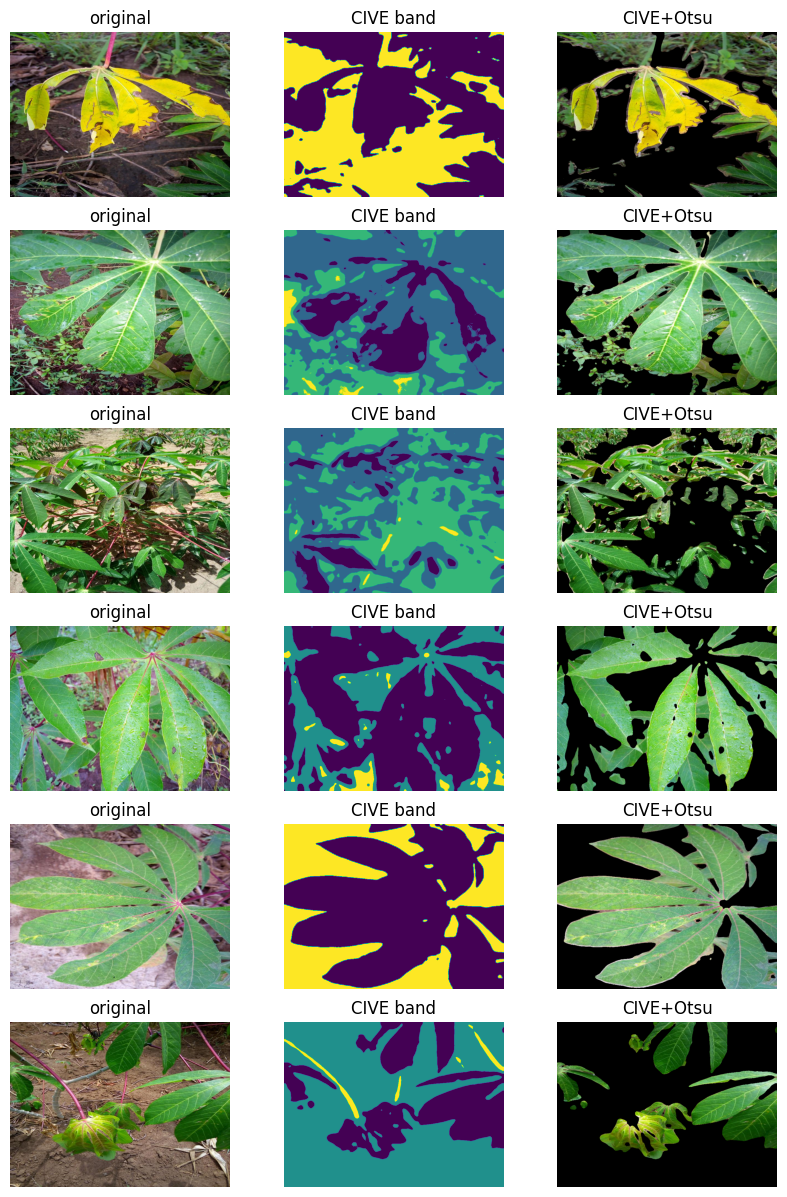

In [7]:
plt.figure(figsize=(10, 15))
items = 6
for idx, image_id in enumerate(samples_df.image_id[:items]):
   img_path = training_folder+image_id
   img = np.array(Image.open(img_path))
   ax = plt.subplot(items, 3, idx*3 + 1)
   ax.set_title("original")
   plt.axis('off')
   plt.imshow(img)
   
   CIVE_band = get_CIVE_band(img)
   ax = plt.subplot(items, 3, idx*3 + 2)
   ax.set_title("CIVE band")
   plt.axis('off')
   plt.imshow(CIVE_band)
   
   masked_img = apply_CIVE_mask(img, CIVE_band)
   ax = plt.subplot(items, 3, idx*3 + 3)
   ax.set_title("CIVE+Otsu")
   plt.axis('off')
   plt.imshow(masked_img)

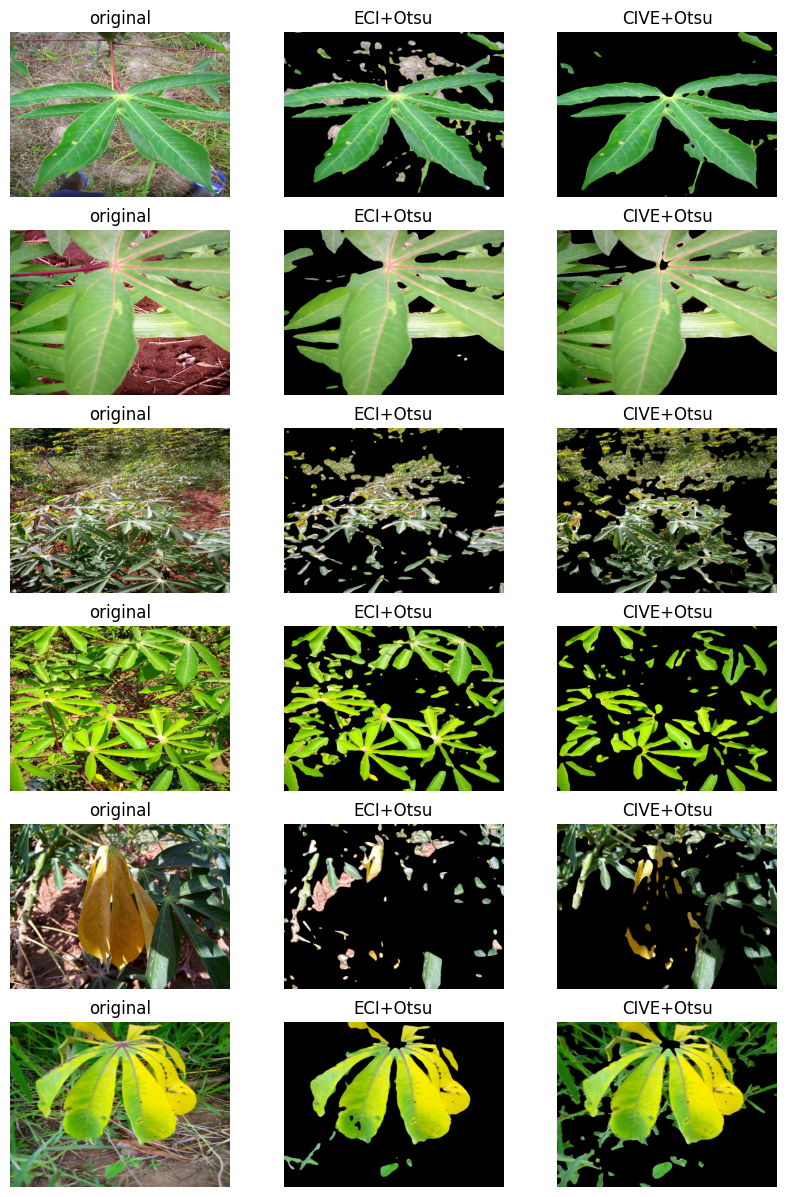

In [8]:
plt.figure(figsize=(10, 15))
items = 6
for idx, image_id in enumerate(samples_df.image_id[10:10+items]):
   img_path = training_folder+image_id
   img = np.array(Image.open(img_path))
   ax = plt.subplot(items, 3, idx*3 + 1)
   ax.set_title("original")
   plt.axis('off')
   plt.imshow(img)
   
   ECI_band =  get_ECI_band(img)
   CIVE_band = get_CIVE_band(img)

   masked_img = apply_ECI_mask(img, ECI_band)
   ax = plt.subplot(items, 3, idx*3 + 2)
   ax.set_title("ECI+Otsu")
   plt.axis('off')
   plt.imshow(masked_img)
   
   masked_img = apply_CIVE_mask(img, CIVE_band)
   ax = plt.subplot(items, 3, idx*3 + 3)
   ax.set_title("CIVE+Otsu")
   plt.axis('off')
   plt.imshow(masked_img)